# Layout methods

See [Graph_drawing](https://en.wikipedia.org/wiki/Graph_drawing)

## Force-directed graph drawing

See this nice overview in Wikipedia for [Force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) and also [this paper](https://cs.brown.edu/people/rtamassi/gdhandbook/chapters/force-directed.pdf)

* [Hooke's law](https://en.wikipedia.org/wiki/Hooke%27s_law) is used for attracting nodes to each other.
* [Coulomb's law](https://en.wikipedia.org/wiki/Coulomb%27s_law) is used to repulse nodes from each other.
* Edge attraction and Node repulsion forces do not have to be physically accurate.
* Some force-directed systems use springs whose attractive force is logarithmic rather than linear.
* An alternative model considers a spring-like force where there is an ideal length for each spring without using a separate repulsive force. See [Multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling)
* Alternatively, gravity may be used to pull the nodes towards a fixed point.
* Magnetic fields could be used for directed graphs.
* Repulsive forces may be placed on edges as well as on nodes in order to avoid overlaps.
* In drawings with curved edges such as circular arcs or spline curves, forces may also be placed on the control points of these curves, for instance to improve their angular resolution.
* Traditional energy models enforce small and uniform edge lengths. This could prevent the separation of nodes in different clusters.
* A strategy for drawing a graph nicely is to abstract it without the fine details.

### Hooke's law

The force needed to extend or compress a spring by some distance scales linearly.

* spring constant k is a measure of the stiffness.
* extension is the increase in length

In [487]:
# linear springs
def force(k: float, extension: float):
    return k*extension

In [488]:
force(2, 10)

20

Algorithm of Fruchterman and Reingold with even vertex distribution.
This algorithm is similar to that of Eades with attractive forces between adjacent nodes and repulsive forces between all pairs of nodes.

The algorithm adds the notion of temperature which would decrease to 0. 
The temperature (similar in concept to [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) )influences the displacement of nodes to make the layout better. 

* d, distance between two nodes
* k, optimal distance between nodes
* area

In [489]:
from math import sqrt

def optimal_distance(c, area, numberOfNodes: int):
    return c*sqrt(area/numberOfNodes)

In [490]:
k_dist = optimal_distance(1, 1024*768, 30)
k_dist

161.90861620062103

In [491]:
def force_attractive(d: float):
    return d**2/k_dist

In [492]:
force_attractive(100)

61.76323555016366

In [493]:
def force_repulsive(d: float):
    return (-k_dist**2)/d

In [494]:
force_repulsive(100)

-262.144

## Kamada and Kawai approach

Desirable geometric (Euclidean) distance between two nodes in the drawing as the graph theoretic distance as computed by an All-Pairs-Shortest-Path computation. The algorithm shows an intuitive definition of a good graph layout.
However, it is more expensive to run.


## Random graph

A simplified graph for which nodes are just ids

In [495]:
from typing import Tuple, List
from random import randint, choice, sample

class Edge:
    def __init__(self, from_id: int, to_id: int):
        self.from_id = from_id
        self.to_id = to_id
        
    def __repr__(self):
        return f"{self.from_id}->{self.to_id}"
    
    def __str__(self):
        return f"{self.from_id}->{self.to_id}"
    
class Graph:
    def __init__(self, nb_of_nodes: int):
        self.edges = []
        self.nb_of_nodes = nb_of_nodes
        self.tmp_nb_of_nodes = 0
        
    def random_nodes(self, excluding: List[int], k: int):
        options = list(set(range(self.nb_of_nodes)).difference(set(excluding)))
        if k > len(options):
            return []
        return sample(options, k)
        
    def random_graph(self, childRange: Tuple[int, int]):
        edges = []
        for i in range(self.nb_of_nodes):
            childCount = randint(childRange[0], childRange[1])
            if childCount < 1:
                continue
            childNodeIds = self.random_nodes([i], childCount)
            for c in childNodeIds:
                edges.append(Edge(i, c))
        self.edges = edges
        return self
    
    def random_tree_child(self, current_node_id: int, max_children: int):
        if self.tmp_nb_of_nodes >= self.nb_of_nodes - 1:
            return
        child_count = randint(1, max_children)
        tmp_nb_of_nodes = self.tmp_nb_of_nodes
        self.tmp_nb_of_nodes = tmp_nb_of_nodes + child_count
        for i in range(child_count):
            new_child_id = tmp_nb_of_nodes+i
            self.edges.append(Edge(current_node_id, new_child_id))
            self.random_tree_child(new_child_id, max_children)
        
        
    def random_tree(self, max_children: int):
        # a node has a single parent
        self.random_tree_child(0, max_children)
        return self
   

In [496]:
g12 = Graph(12).random_graph((0, 3))
g1.edges

[0->5,
 0->8,
 0->7,
 2->9,
 2->3,
 4->2,
 6->9,
 6->4,
 7->1,
 7->4,
 7->8,
 8->2,
 10->8,
 11->10,
 11->9,
 11->7]

In [497]:
t12 = Graph(20).random_tree(max_children=3)
t12.edges

[0->0,
 0->3,
 3->4,
 4->6,
 6->7,
 7->8,
 8->9,
 9->12,
 12->14,
 14->15,
 15->18,
 14->16,
 14->17,
 9->13,
 8->10,
 8->11,
 3->5,
 0->1,
 0->2]

In [498]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

Point2D = namedtuple('Point2D',('x','y'))

class VisualNode:
    def __init__(self):
        self.pt: Point2D = Point2D(0, 0)
    
    def set_point(self, pt: Point2D):
        self.pt = pt
        return self
    
    def set_random_point(self, width: int, height: int):
        x = randint(1, width-1)
        y = randint(1, height-1)
        return self.set_point(Point2D(x, y))
    
    def __repr__(self):
        return f"{self.pt}"
    
    def __str__(self):
        return f"{self.pt}"
    
class VisualGraph:
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        self.nodes = []
        self.edges = []
    
    def from_graph(self, graph):
        self.edges = graph.edges
        self.nodes = [ VisualNode().set_random_point(self.width, self.height) for _ in range(graph.nb_of_nodes)]
        return self
            
    def get_x(self):
        return [self.nodes[ve.from_id].pt.x for ve in self.edges]
    
    def get_y(self):
        return [self.nodes[ve.from_id].pt.y for ve in self.edges]
    
    def get_u(self):
        return [self.nodes[ve.to_id].pt.x-self.nodes[ve.from_id].pt.x for ve in self.edges]
    
    def get_v(self):
        return [self.nodes[ve.to_id].pt.y-self.nodes[ve.from_id].pt.y for ve in self.edges]
    
    def quiver_show(self):
        X = np.array(self.get_x())
        Y = np.array(self.get_y())
        U = np.array(self.get_u())
        V = np.array(self.get_v())
        fig, ax = plt.subplots()
        q = ax.quiver(X, Y, U, V)
        ax.quiverkey(q, X=1, Y=1, U=1, label='Graph', labelpos='N')
        return plt.show()

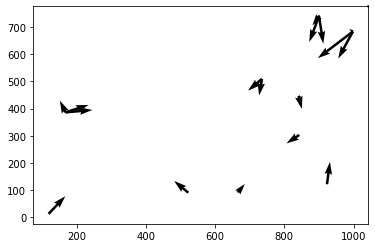

In [499]:
vgt12 = VisualGraph(1024, 768).from_graph(t12)
vgt12.quiver_show()